# Empirical evaluation using real data

Whilst simulating data offers unparalleled control of testing conditions, it carries with it the risk that the synthetic data generation procedure is not representative of the generative procedures underlying the real-world datasets on which the models are applied in practice. As such, a means by which to complement simulation based approaches with evaluation of model performance on real datasets is highly desirable. Unfortunately, because of the fundamental problem of causal inference, we may never observe a true counterfactual against which to compare our models. To overcome this limitation, I propose to fit models to units where the estimated quantity is the observed potential outcome, namely control units. Specifically, we isolate one control unit in a dataset used for SC, pretend it was subjected to a treatment at some time T0, and fit a synthetic control unit to it using the remaining control units as the donor pool. Because the control unit never received the treatment, the true treatment effect is zero. Consequently, we can compare models based on how close, as measured using RMSPE, the synthetic control units are to the observed post-treatment outcome. We repeat this procedure for every control unit across several datasets from published studies applying synthetic control methodology, such that the assumptions of the model hold for the units in the dataset, and report the pre-treatment RMSPE, the post-treatment RMSPE, and the pre/post-treatment RMSPE ratio for the SC, SDID and DSC.

N.B.: Remaining subsections under this section are unfinished

In [62]:
import pandas as pd
import numpy as np
from SyntheticControlMethods import Synth, DiffSynth
import pandas_profiling as pp
import matplotlib.pyplot as plt

In [8]:
def compare_and_save(storage_df, dataset_loc, 
                     outcome_var, id_var, time_var,
                     treatment_period, treated_unit,
                     n_optim=10, ignore_cols = None):
    '''
    Approach:
    1. Take a dataset, drop the treated unit
    2. For each control unit:
        1. Fit Synthetic control using other control units as donor pool, record RMSPE
        2. Same but with Differenced Synthetic Control
    3. Repeat above for all datasets
    '''
    
    #Get models
    models = [Synth, DiffSynth]
    model_names = ["SC", "DSC"]
    penalization = [0, "auto"]
    
    #Get data
    data_dir = "https://raw.githubusercontent.com/OscarEngelbrektson/SyntheticControlMethods/master/examples/datasets/"
    df = pd.read_csv(data_dir + dataset_loc + ".csv")
    df = df.loc[df[id_var] != treated_unit] #Drop treated_unit
    
    #Extract names of all control units
    units = df[id_var].unique()
    for unit in units: #For every control unit
        for model_name, model in zip(model_names, models): #For both SC and DSC
            for pen in penalization:
                if model_name == "SC":
                    #Fit SC
                    synth = model(df, outcome_var, id_var, time_var, treatment_period, unit, 
                                n_optim=n_optim, pen=pen)
                    
                    #Save results
                    model_name += "_pen" if type(pen)==str else "" #Add suffix _pen if penalization != 0
                    storage_df = store(storage_df, dataset_loc, unit, model_name, synth, constant=False)

                else: #if model is DiffSynth
                    #Fit DSC
                    synth = model(df, outcome_var, id_var, time_var, treatment_period, unit, 
                                  ignore_cols=ignore_cols, n_optim=n_optim, pen=pen)
                    #Save results
                    model_name += "_pen" if type(pen)==str else "" #Add suffix _pen if penalization != 0
                    storage_df = store(storage_df, dataset_loc, unit, model_name, synth, constant=True)
    
    #Store as csv
    storage_df.to_csv("empirical_model_comparison.csv", index=False, header=True)
    #storage_df.to_parquet("empirical_model_comparison.csv", index=False)
    return storage_df
    
    
def store(storage_df, dataset, unit, model, synth, constant):
    '''Extract relevant model metrics and save to storage_df'''
    #For convience
    data = synth.original_data
    #Make df with one observation
    synth_df = pd.DataFrame({"Dataset": [dataset],
                              "Control Unit": [unit],
                              "Method": [model],
                              "Pre RMSPE": [float(data.rmspe_df["pre_rmspe"])],
                              "Post RMSPE": [float(data.rmspe_df["post_rmspe"])],
                              "Post/pre RMSPE ratio": [float(data.rmspe_df["post/pre"])],
                              "W": [data.w],
                              "Constant": [None if (model == "SC") or (model == "SC_pen") else data.synth_constant],
                              "Pen": [None if (model == "SC") or (model == "DSC") else data.pen]})
    
    #Return storage_df with new observation appended to end
    return pd.concat([storage_df, synth_df], axis=0)

## Run for all datasets

In [9]:
storage_df = pd.DataFrame({"Dataset": [],
                              "Control Unit": [],
                              "Method": [],
                              "Pre RMSPE": [],
                              "Post RMSPE": [],
                              "Post/pre RMSPE ratio": [],
                              "W":[],
                              "Constant":[],
                              "Pen":[]})

In [10]:
storage_df = compare_and_save(storage_df, "smoking_data",
                 "cigsale", "state", "year", 1989, "California", 10)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [11]:
storage_df = compare_and_save(storage_df, "german_reunification", 
                 "gdp", "country", "year", 1990, "West Germany", 
                 10, ["schooling", "invest60", "invest70", "invest80"])

In [12]:
storage_df = compare_and_save(storage_df, "basque_data", 
                 "gdpcap", "regionname", "year", 1990, "Basque Country (Pais Vasco)", 
                 10,['sec.agriculture', 'sec.energy',
                   'sec.industry', 'sec.construction', 'sec.services.venta',
                   'sec.services.nonventa', 'school.illit', 'school.prim', 'school.med',
                   'school.high', 'school.post.high'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver sett

### Compute sparsity from weights

In [186]:
np.count_nonzero(np.round(storage_df.iloc[1]["W"], 5))

2

In [202]:
storage_df.drop(columns=["sparsity"], axis=1, inplace=True)

def proportion_of_non_zero_weights(row):
    '''
    Takes weight vector of a given synthetic control
    Returns the proportion of units assigned 0 weight
    '''
    W = np.round(row["W"], 5)
    return np.count_nonzero(W)/len(W)

#Compute sparsity from weights
storage_df["Sparsity"] = storage_df.apply(proportion_of_non_zero_weights, axis=1)

# Analyze Results

dimensions to analyse:
2. Sparsity of w
3. pre
4. post

Ideas: make violin plot that somehow shows pre,post and ratio for the groups in one

In [191]:
storage_df.head(10)

,Dataset,Control Unit,Method,Pre RMSPE,Post RMSPE,Post/pre RMSPE ratio,W,Constant,sparsity
0,smoking_data,Alabama,SC,9.328027,15.541616,1.666120,"[[2.7716309167451333e-22], [0.0], [2.178085951...",None,0.054054
0,smoking_data,Alabama,SC_pen,6.414143,6.560237,1.022777,"[[0.6248814064601804], [4.173320802675706e-22]...",None,0.054054
0,smoking_data,Alabama,DSC,1.589902,2.609516,1.641306,"[[0.31382533094150045], [4.5720303967809914e-1...",-10.7703,0.081081
0,smoking_data,Alabama,DSC_pen,3.051299,4.183617,1.371094,"[[0.4374460254791192], [8.541617759549765e-21]...",-8.57908,0.054054
0,smoking_data,Arkansas,SC,15.826894,33.221416,2.099048,"[[0.0], [0.0], [1.6271352733489517e-23], [0.0]...",None,0.054054
0,smoking_data,Arkansas,SC_pen,7.317211,8.709956,1.190338,"[[2.8388690635852446e-22], [1.4673591645140733...",None,0.027027
0,smoking_data,Arkansas,DSC,3.420261,4.378816,1.280258,"[[0.8970026195178709], [1.1800980586623648e-05...",6.86355,0.945946
0,smoking_data,Arkansas,DSC_pen,2.985855,4.379868,1.466872,"[[0.9445549434597713], [1.7440514419080682e-19...",6.62095,0.054054
0,smoking_data,Colorado,SC,3.531586,3.186158,0.902189,"[[4.466166806030513e-23], [0.0], [0.0], [4.594...",None,0.054054
0,smoking_data,Colorado,SC_pen,5.288792,5.228060,0.988517,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",None,0.054054


In [203]:
def color_map(x):
    '''
    Maps a rank to a colour,
    Red-er is low rank, blue-er is high rank
    '''
    color_dict = {1 : 'background-color: #9fbbffff',
                  1.5 : 'background-color: #9fbbffff',
                  2 : 'background-color: #cedcffff',
                  3 : 'background-color: #ffccccff',
                  4 : 'background-color: #ffa8a8ff'}
    return color_dict[x]

def highlight_by_order(df):
    '''
    Takes grouped data frame,
    Produces columnwise ranks for each observation in each group,
    then returns dataframe of colours based on ranks, as per colormap
    '''
    rank_df = df.groupby(level=0).rank().astype(int)
    color_df = rank_df.applymap(color_map)
    return color_df

#Compute Pre RMSPE, Post RMSPE and sparsity for each method for each dataset
summary_df = storage_df.groupby(["Dataset","Method"])[["Pre RMSPE", "Post RMSPE", "Sparsity"]].agg([np.mean]).round(2)
summary_df.style.apply(highlight_by_order,axis=None).format("{:.2f}")

In [73]:
storage_df.groupby("Method")[["Pre RMSPE", "Post RMSPE"]].median()

,Pre RMSPE,Post RMSPE
Method,,
DSC,5.373029,12.983969
DSC_pen,4.586791,11.027258
SC,6.313807,11.448270
SC_pen,5.690666,10.904216


In [15]:
storage_df.groupby("Method")["Post RMSPE"].describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
DSC,71.0,378.383526,936.512529,0.055154,3.046097,12.983969,41.838508,5339.398578
DSC_pen,71.0,400.697599,1037.641309,0.052674,3.286188,11.027258,31.017696,6590.173748
SC,71.0,443.515242,1061.206455,0.149917,2.622206,11.448270,31.657353,4903.074522
SC_pen,71.0,422.261286,1011.227896,0.079737,2.474950,10.904216,26.584453,4903.070663


In [16]:
storage_df.groupby("Method")["Pre RMSPE"].describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
DSC,71.0,84.228178,202.733662,0.035286,1.853866,5.373029,16.038359,1195.289032
DSC_pen,71.0,87.660030,193.946458,0.041263,2.010931,4.586791,14.697943,813.284176
SC,71.0,149.626936,357.076143,0.047939,2.943543,6.313807,23.757556,1468.720600
SC_pen,71.0,132.136539,320.261567,0.047939,2.265696,5.690666,23.877879,1468.720600


## Segregating by Dataset too

In [71]:
storage_df.loc[storage_df["Method"]!="DSC"].groupby(["Dataset","Method"])["Pre RMSPE"].describe()

count        mean         std         min  \
Dataset              Method                                               
basque_data          DSC_pen   17.0    0.168324    0.199328    0.041263   
                     SC        17.0    0.371908    0.417829    0.047939   
                     SC_pen    17.0    0.318758    0.341410    0.047939   
german_reunification DSC_pen   16.0  374.508888  249.338636   74.806595   
                     SC        16.0  642.603027  509.984177  107.507871   
                     SC_pen    16.0  566.662975  467.310977  107.507871   
smoking_data         DSC_pen   38.0    6.022591    4.072573    1.890676   
                     SC        38.0    8.830042    9.802580    2.856920   
                     SC_pen    38.0    8.149153    9.665210    1.686994   

                                     25%         50%          75%          max  
Dataset              Method                                                     
basque_data          DSC_pen    0.074363    0.095730     0.151309     0.886419  
                     SC         0.125772    0.196310     0.311097     1.334174  
                     SC_pen     0.109213    0.139346     0.547939     1.118919  
german_reunification DSC_pen  182.785510  310.313644   508.851357   813.284176  
                     SC       278.662357  404.710599  1173.010202  1468.720600  
                     SC_pen   246.388041  341.754289   860.302124  1468.720600  
smoking_data         DSC_pen    3.147595    4.676125     7.154221    20.553060  
                     SC         4.789540    6.328239     8.176501    60.480521  
                     SC_pen     4.275081    5.695454     7.352044    59.037758

In [64]:
storage_df.loc[storage_df["Method"]!="DSC"].groupby(["Dataset","Method"])["Post RMSPE"].describe()

count         mean          std         min  \
Dataset              Method                                                 
basque_data          DSC_pen   17.0     0.360865     0.279662    0.052674   
                     SC        17.0     0.613536     0.530151    0.149917   
                     SC_pen    17.0     0.519704     0.388969    0.079737   
german_reunification DSC_pen   16.0  1747.066117  1590.048856  364.655930   
                     SC        16.0  1934.764618  1480.860719  452.781331   
                     SC_pen    16.0  1841.985706  1412.902572  452.781545   
smoking_data         DSC_pen   38.0    12.903604     8.416403    2.779227   
                     SC        38.0    13.761006     8.683025    1.991559   
                     SC_pen    38.0    13.156449     8.675855    1.991559   

                                     25%          50%          75%  \
Dataset              Method                                          
basque_data          DSC_pen    0.227866     0.272679     0.514760   
                     SC         0.261849     0.468603     0.679174   
                     SC_pen     0.258782     0.391333     0.710490   
german_reunification DSC_pen  882.791983  1256.291722  1864.496583   
                     SC       876.470483  1211.107867  2979.081253   
                     SC_pen   876.896285  1211.116662  2773.197254   
smoking_data         DSC_pen    5.485051    11.211970    17.293285   
                     SC         7.400004    11.525945    17.279512   
                     SC_pen     7.206910    11.156274    17.289061   

                                      max  
Dataset              Method                
basque_data          DSC_pen     1.198214  
                     SC          2.058255  
                     SC_pen      1.623908  
german_reunification DSC_pen  6590.173748  
                     SC       4903.074522  
                     SC_pen   4903.070663  
smoking_data         DSC_pen    32.632885  
                     SC         41.164310  
                     SC_pen     47.254400

## Visualizing it

(Best visualization in still TBD, so far tables are most convincing IMO)

In [32]:
#Make seperate DFs
sc_df = storage_df.loc[storage_df["Method"]=="SC"]
dsc_df = storage_df.loc[storage_df["Method"]=="DSC"]
sc_pen_df = storage_df.loc[storage_df["Method"]=="SC_pen"]
dsc_pen_df = storage_df.loc[storage_df["Method"]=="DSC_pen"]

# Violin Plots

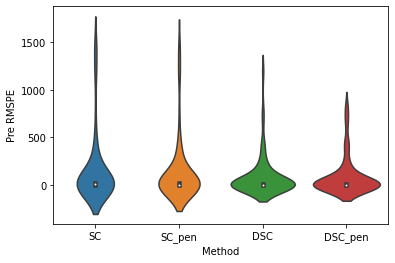

In [24]:
sns.violinplot(x='Method', y='Pre RMSPE', data=storage_df, order=[ "SC", "SC_pen", "DSC", "DSC_pen"])
plt.show()

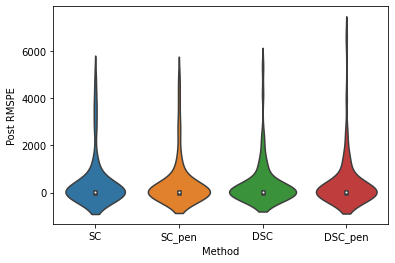

In [25]:
sns.violinplot(x='Method', y='Post RMSPE', data=storage_df, order=[ "SC", "SC_pen", "DSC", "DSC_pen"])
plt.show()

In [55]:
def violin_plot(statistic, dataset):    
    sns.violinplot(x='Method', y=statistic, data=storage_df.loc[storage_df["Dataset"]==dataset],
                   order=[ "SC", "SC_pen", "DSC", "DSC_pen"],
                   title=dataset + " : " + statistic,
                   showmeans=True, showextrema=True, showmedians=True)
    plt.show()

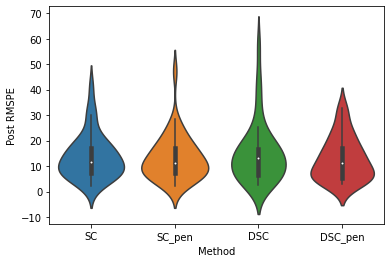

In [56]:
violin_plot('Post RMSPE', "smoking_data")

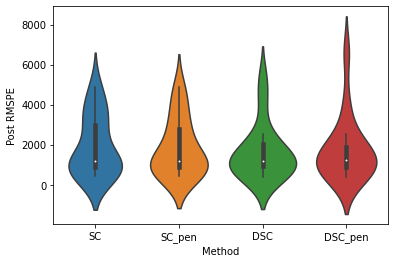

In [60]:
violin_plot('Post RMSPE', "german_reunification")

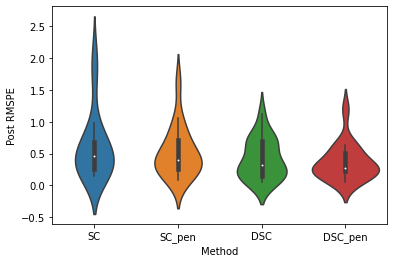

In [61]:
violin_plot('Post RMSPE', "basque_data")

# Kernel Density Histograms

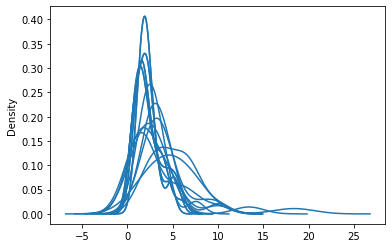

In [44]:
ax = storage_df.loc[storage_df["Dataset"] == "smoking_data"].groupby("Method")["Post/pre RMSPE ratio"].plot(kind="density", subplots=True)
ax = storage_df.groupby(["Dataset", "Method"])["Post/pre RMSPE ratio"].plot(kind="density", subplots=True)


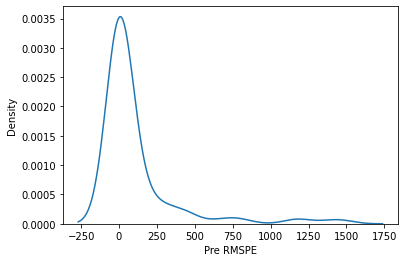

In [30]:
sns.kdeplot(x='Pre RMSPE', data=storage_df, columns=[ "SC", "SC_pen", "DSC", "DSC_pen"])
plt.show()